<a href="https://colab.research.google.com/github/SophieShin/NLP_22_Fall/blob/main/%5BSSH%5Dlab05_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification using AG News
- The `AG_NEWS` dataset has news on four topics with the following labels:
            1: "World"
            2: "Sports"
            3: "Business"
            4: "Sci/Tec"
- You may use GPU for this lab if you want quicker results (Change Runtime) but CPUs should be ok too (CPU training takes 3-3.5m mins)


In [1]:
# Install prerequisite
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 140 kB 64.4 MB/s 
     |████████████████████████████████| 127 kB 48.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Access to the raw data as an iterator

In [12]:
import torch
import torchdata

from torchtext.datasets import AG_NEWS

train_iter = iter(AG_NEWS(split='train'))

# The torchtext library provides a few raw dataset iterators, which yield the raw text strings. 
# For example, the AG_NEWS dataset iterators yield the raw data as a tuple of label and text.

View some items in this dataset

In [15]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

In [16]:
next(train_iter)

(3,
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')

In [5]:
# Q1. What does each entry in the iterator represent with regards to a news piece?
# A1. train_iter is iterable object therefore next(train_iter) represent what data there is in train_iter by the order one by one.

### Prepare data
- Use `get_tokenizer()` to create tokens from the `basic_english` language
- Generate a token for each word in the training set. More on `yield` [HERE](https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do)
- Build the vocabulary using `build_vocab_from_iterator()`

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

train_iter = iter(AG_NEWS(split='train'))


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"], min_freq=10)
# The first step is to build a vocabulary with the raw training dataset.
# Here we use built in factory function build_vocab_from_iterator 
# which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.

vocab.set_default_index(vocab["<unk>"])

# Q2. What does the last line of code do?
# A2. The first line means building vocab set with yield_token funtion(tokenization) and putting special token as 'unknown'.
#     Also, this allows to bulid vocab with words that appear more than 10 times. If some words appear less than 10, 
#     this would not be involoved in the vocab list. 
#     The second line makes the unknown token to have the index 0

# Q3. Would the vocab size be higher or lower if min_freq was set to something smaller? Why?
# A3. If the min_freq is larger, then the vocab size will be smaller because there are less words that appear more than 10 times. And vice versa.


In [18]:
# The vocabulary block converts a list of tokens into integers.
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

### Text and Label Pipelines
- The text and label pipelines will be used to process the raw data strings from the dataset iterators


- The label pipeline converts the label into integers

In [7]:
# Prepare the text processing pipeline with the tokenizer and vocabulary.
# The text and label pipelines will be used to process the raw data strings from the dataset iterators.

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [8]:
text_pipeline("Welcome...unicorns, to my mystical world!")

[3314, 1, 1, 1, 0, 3, 4, 1300, 0, 50, 764]

In [9]:
# Q4. How many tokens does this sentence have? Does this match the number of words in the sentence? Why?
# A4. There are 14 tokens in this sentence and this matches the number of words.

# Q5. Looking at the token values, are there any of them not contained in the vocab? Which one(s)?
# A5. 'unicorns' is not in the vocab therefore its index is 0(unknown).

- The label pipeline converts the label into integers

In [10]:
label_pipeline(4)

3

### Data Batch and Iterator
- we will use DataLoader that we are already familiar with
- we will write `collate_fn` function to work on a batch of samples generated from DataLoader
- it will take a batch from the DataLoader and processes them according to the data processing pipelines declared previously
- the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of `nn.EmbeddingBag` later
- The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor

In [19]:
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         # Get the label
         label_list.append(label_pipeline(_label)) # get the label
         # Get the tokens for each text entry
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) # torch.long
         # Store tokens in text_list
         text_list.append(processed_text)
         # Get index of the current text entry
         offsets.append(processed_text.size(0)) # returns the size of the 1st dimension of the tensor
        #  offsets.append(len(processed_text)) # returns the size of the 1st dimension of the tensor
    label_list = torch.tensor(label_list, dtype=torch.int64)
    # The number of tokens for each news entry is added cumulatively
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # cumulative sum of the first dimension
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


# Q6. What is "offsets" and why is it required for this dataset?
# A6. It tells you that on which index the new sentence starts. It allows us to know where the new sentence starts.

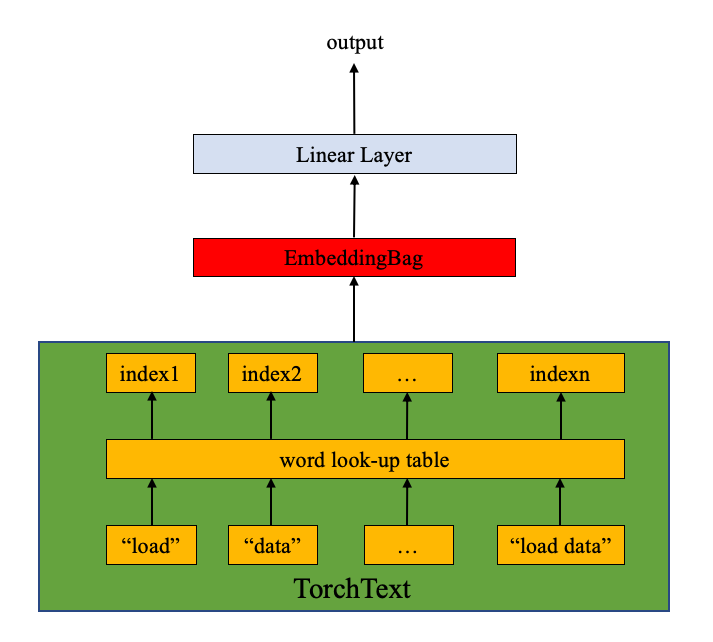

### Define the NN Model
- consists of an embedding layer and a linear layer
- the `nn.EmbeddingBag` layer computes sums or means of `bags` of embeddings, without instantiating the intermediate embeddings


In [22]:
from torch import nn

class TextClassModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    # Define a fn to initialise weights. 
    # Others: nn.init.kaiming_(fc.weight, -initrange, initrange), nn.init.xavier_(fc.weight, -initrange, initrange)
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Q7. Why is padding not required when using EmbeddingBag()?
# A7. Since it concates all the sample data and know the position that the next data starts with offset array. 

### Build model instance

In [23]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter])) # derive the unique class labels
vocab_size = len(vocab)
emb_size = 64

model = TextClassModel(vocab_size, emb_size, num_class).to(device)

# Q8. What would be the vector dimension for each word in the vocabulary?
# A8. The embedding dimension is 64. 

In [26]:
vocab_size

20644

### Functions for Training and Evaluation

In [27]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # gradient clipping (later)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

Split the dataset and run
- the original data was not split into train/validation
- use `torch.utils.data.dataset.random_split` to split the data
- `torch.optim.lr_scheduler.StepLR` decays the learning rate of each parameter group by `gamma` every `step_size` epochs
- `to_map_style_dataset()` converts iterable-style dataset to map-style dataset. This is needed because iterables do not have `__getitem__()` and therefore cannot be indexed


In [28]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 32 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Split the dataset
num_train = int(len(train_dataset) * 0.9)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

# Q9. How is the dataset split and what is the ratio between train, validation and test sets?
# A9. The train_dataset is splited into two group train and validation with the ratio of 9:1.

### Timeout: Default DataLoader behaviour (Automatic Batching)
- What if we do not supply a collate function?
- How does DataLoader's default collate_fn work?
  - Adds a new dimension to the beginning of the tensor (batch) and combines the data in the batch along that dimension.
  - It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.
  - Batch the elements into a tensor while preserving the structure of the data (eg dict, list, tuple, namedtuple, etc.)

- However, if our data has varying lengths, like news or text reviews, we will need to pad them to be of fixed lengths before sending them to the NN input later.
- So we will need to write our own collate_fn to handle this

In [32]:
import numpy as np

reviews = [
        (0, "This is awful."),
        (1, "Great"),
        (1, "Fab!"),
        (0, "Boring")
    ]

dataloader = DataLoader(reviews, batch_size=2)

for label, rev in dataloader:
  print(f"label: {label}")
  print(f"text: {rev}")


label: tensor([0, 1])
text: ('This is awful.', 'Great')
label: tensor([1, 0])
text: ('Fab!', 'Boring')


In [33]:
# Enumerate gives us the index for the batch
for idx, (lbl, txt) in enumerate(dataloader):
  print(f"batch: {idx}")
  print(f"label: {lbl}")
  print(f"text: {txt}")


batch: 0
label: tensor([0, 1])
text: ('This is awful.', 'Great')
batch: 1
label: tensor([1, 0])
text: ('Fab!', 'Boring')


In [35]:
train_iter, test_iter = AG_NEWS()

tr_loader = DataLoader(train_iter, batch_size=2,
                              shuffle=True)

for label, news in tr_loader:
  print(f"label: {label}")
  print(f"news: {news}")
  break;


label: tensor([2, 2])
news: ("California overpowers N. Carolina Danny Leon hit a two-run homer, and Tyler Carp and John Lister added solo homers to lead California (1-0) to a 9-2 victory over North Carolina (1-1) yesterday in the Little League World Series at South Williamsport, Pa. The runs came quickly. California batted around in the third inning to take a 6-0 lead. Leon's shot to center and Lister's ...", 'Baseball Today (AP) AP - Minnesota at Texas (8:05 p.m. EDT). Johan Santana (13-6) starts for the AL Central-leading Twins against Kenny Rogers (15-5).')


More complex data
- If each sample is a dictionary, it outputs a dictionary with the same set of keys but batched Tensors as values (or lists if the values can not be converted into Tensors). Same for lists, tuples, namedtuples, etc.

In [36]:
person_data = [
        [0, "Ada", {"height": 153.1, "feature": np.array([1,2,3])}],
        [1, "Bob", {"height": 172.5, "feature": np.array([3,2,1])}]
    ]

dataloader = DataLoader(person_data, batch_size=2)
for _, (label, text, dic) in enumerate(dataloader):
  print(f"label: {label}")
  print(f"text: {text}")
  print(f"dic: {dic}")


label: tensor([0, 1])
text: ('Ada', 'Bob')
dic: {'height': tensor([153.1000, 172.5000], dtype=torch.float64), 'feature': tensor([[1, 2, 3],
        [3, 2, 1]])}


### Back to News Classification
### Train & Evaluate
- Training takes around 3-3.5 minutes on CPU
- **NOTE!** If the training code is too slow (you do not see the first output within 1 minute), restart your runtime and start over

In [37]:
total_acc = None

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    acc_val = evaluate(valid_dataloader)
    if total_acc is not None and total_acc > acc_val:
      scheduler.step()
    else:
       total_acc = acc_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           acc_val))
    print('-' * 59)

| epoch   1 |   500/ 3375 batches | accuracy    0.637
| epoch   1 |  1000/ 3375 batches | accuracy    0.842
| epoch   1 |  1500/ 3375 batches | accuracy    0.861
| epoch   1 |  2000/ 3375 batches | accuracy    0.869
| epoch   1 |  2500/ 3375 batches | accuracy    0.878
| epoch   1 |  3000/ 3375 batches | accuracy    0.888
-----------------------------------------------------------
| end of epoch   1 | time: 15.99s | valid accuracy    0.893 
-----------------------------------------------------------
| epoch   2 |   500/ 3375 batches | accuracy    0.902
| epoch   2 |  1000/ 3375 batches | accuracy    0.898
| epoch   2 |  1500/ 3375 batches | accuracy    0.902
| epoch   2 |  2000/ 3375 batches | accuracy    0.903
| epoch   2 |  2500/ 3375 batches | accuracy    0.906
| epoch   2 |  3000/ 3375 batches | accuracy    0.905
-----------------------------------------------------------
| end of epoch   2 | time: 15.47s | valid accuracy    0.901 
--------------------------------------------------

In [ ]:
# Q10. Why are the train and test datasets converted to map style datasets?
# A10. If we store index and the data, then dataloader can easily access the data with the index. 


Evaluate the model with test dataset

In [38]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.912


Test on a random news


In [39]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


In [40]:
# Q11. Think of ways to further improve the accuracy of the model. 
# Put any thoughts or code cells below.
# A11. We may increase the number of epoch. Also we may try to change the optimizer, learning rate. 